In [1]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

import math

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from datetime import datetime, timedelta

# import sqlite3
# from airflow import DAG
# from airflow.utils.dates import days_ago
# from airflow.operators.python_operator import PythonOperator

import nbformat

import warnings
from typing import Optional, Tuple, Callable, Dict, Any, List, Union
import fire

warnings.filterwarnings('ignore')


from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso, Ridge, SGDRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.discriminant_analysis import StandardScaler

from fastapi import FastAPI

import pickle
import os

import streamlit as st
# Create a requirements.txt file with the necessary packages
# !pip freeze > airflow/dags/requirements.txt
sns.set_style('darkgrid')

In [2]:
from app.load_data import load_data_from_source
from app.transform_data import transform_data_into_features_and_targets
from app.baseline_model import train_baseline

from app.train_models import train_model, save_best_model, training_process

from app.model_prediction import predict_res

In [3]:
# ---- VARIABLES ----
explanable_cols = ['Player','Nation','Pos','Squad','Age','Born','Starts','Min','Gls','Total_Att','Blocks_Blocks','Blocks_Sh','Blocks_Pass','Clr','Err','Touches_Touches','Touches_DefPen','Dribbles_Succ','Dribbles_Att','Dribbles_Mis','AerialDuels_Won','AerialDuels_Lost']
file_loc       = 'airflow/dags/assets/matches-checkpoint.csv'
spanish_squads = ['Sevilla', 'Sporting Huelva', 'Athletic Club', 'Levante Planas',
                  'UDG Tenerife', 'Villarreal', 'Madrid CFF', 'Barcelona',
                  'Atlético Madrid', 'Real Madrid', 'Alhama', 'Alavés',
                  'Real Sociedad', 'Levante', 'Real Betis', 'Valencia']

## Load Data

In [4]:
data = load_data_from_source()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, 0 to 86
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Wk         87 non-null     int64  
 1   Day        87 non-null     object 
 2   Date       87 non-null     object 
 3   Time       87 non-null     object 
 4   Home       87 non-null     object 
 5   xGHome     87 non-null     float64
 6   Score      87 non-null     object 
 7   xGAway     87 non-null     float64
 8   Away       87 non-null     object 
 9   Home_id    87 non-null     object 
 10  Away_id    87 non-null     object 
 11  Match_id   87 non-null     object 
 12  League_id  87 non-null     int64  
 13  xPHome     87 non-null     float64
 14  xPAway     87 non-null     float64
 15  ScoreHome  87 non-null     int64  
 16  ScoreAway  87 non-null     int64  
dtypes: float64(4), int64(4), object(9)
memory usage: 12.2+ KB
(87, 17) None


,Wk,Day,Date,Time,Home,xGHome,Score,xGAway,Away,ScoreHome,ScoreAway
0,2,Sat,2022-09-17,12:00,Barcelona,1.9,2–0,0.4,UDG Tenerife,2,0
1,2,Sat,2022-09-17,12:00,Alavés,1.1,1–2,1.2,Madrid CFF,1,2
2,2,Sat,2022-09-17,16:00,Real Sociedad,0.7,2–0,0.3,Villarreal,2,0
3,2,Sat,2022-09-17,16:00,Real Madrid,1.6,2–0,0.8,Valencia,2,0
4,2,Sat,2022-09-17,18:00,Sevilla,1.1,1–3,1.4,Atlético Madrid,1,3


## Transform Data

Transform the loaded data into _features_ and _target_


In [5]:
features_home, target_home = transform_data_into_features_and_targets(df=data, score='Home')
features_away, target_away = transform_data_into_features_and_targets(df=data, score='Away')

# Remember that features_home and features_away are the same, so we can use either one
# However, target_home and target_away are different, so we need to concatenate them in order to have the full target

In [6]:
from sklearn.preprocessing import LabelEncoder

spanish_teams = ['Alavés', 'Alhama', 'Athletic Club', 'Atlético Madrid',
       'Barcelona', 'Levante', 'Levante Planas', 'Madrid CFF',
       'Real Betis', 'Real Madrid', 'Real Sociedad', 'Sevilla',
       'Sporting Huelva', 'UDG Tenerife', 'Valencia', 'Villarreal']

label_enconder = LabelEncoder()
teams = np.unique([data.Home.unique(), data.Away.unique()])
teams_encoded = label_enconder.fit_transform(teams)

teams_encoded

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [7]:
display(data.Home.sort_values(ascending=False).value_counts(),data.Away.sort_values(ascending=False).value_counts())

Home
Villarreal         6
Valencia           6
Sporting Huelva    6
Levante Planas     6
Levante            6
Atlético Madrid    6
Athletic Club      6
Alhama             6
Sevilla            5
Real Sociedad      5
Real Madrid        5
Real Betis         5
Madrid CFF         5
Barcelona          5
Alavés             5
UDG Tenerife       4
Name: count, dtype: int64

Away
UDG Tenerife       6
Sevilla            6
Real Sociedad      6
Real Betis         6
Madrid CFF         6
Barcelona          6
Alavés             6
Villarreal         5
Valencia           5
Sporting Huelva    5
Real Madrid        5
Levante Planas     5
Levante            5
Atlético Madrid    5
Athletic Club      5
Alhama             5
Name: count, dtype: int64

## Exploration

,Wk,Day,Date,Time,Home,xGHome,Score,xGAway,Away,ScoreHome,ScoreAway,Numeric_Day,Numeric_Home,Numeric_Away,Numeric_Time
3,2,Sat,2022-09-17,16:00,Real Madrid,1.6,2–0,0.8,Valencia,2,0,6,9,14,4.0
53,1,Thu,2022-11-03,18:45,Villarreal,0.4,0–4,1.4,Real Madrid,0,4,4,15,9,10.0
56,8,Sat,2022-11-05,12:00,Real Sociedad,1.6,0–2,2.1,Madrid CFF,0,2,6,10,7,2.0
29,5,Sun,2022-10-16,16:00,Alhama,0.9,0–1,0.9,Valencia,0,1,7,1,14,4.0


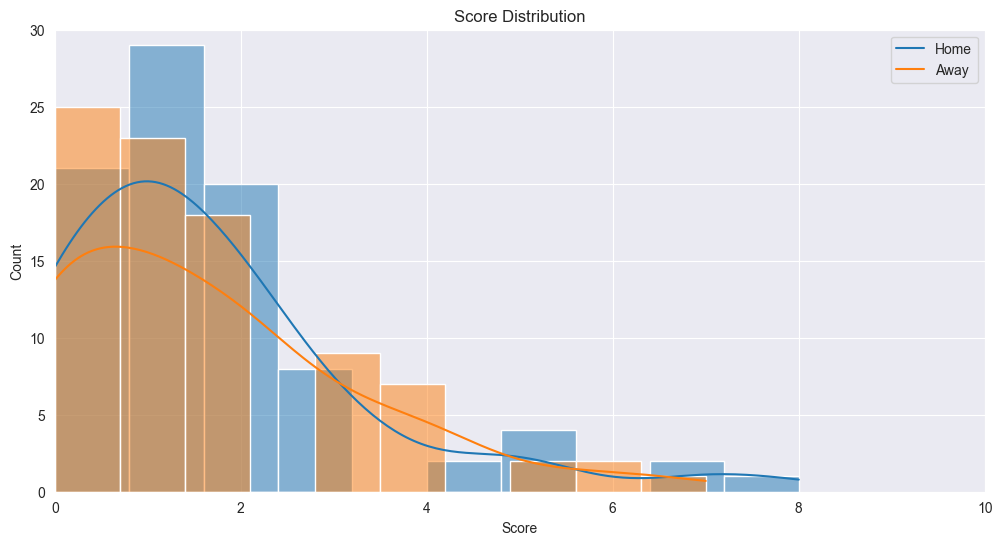

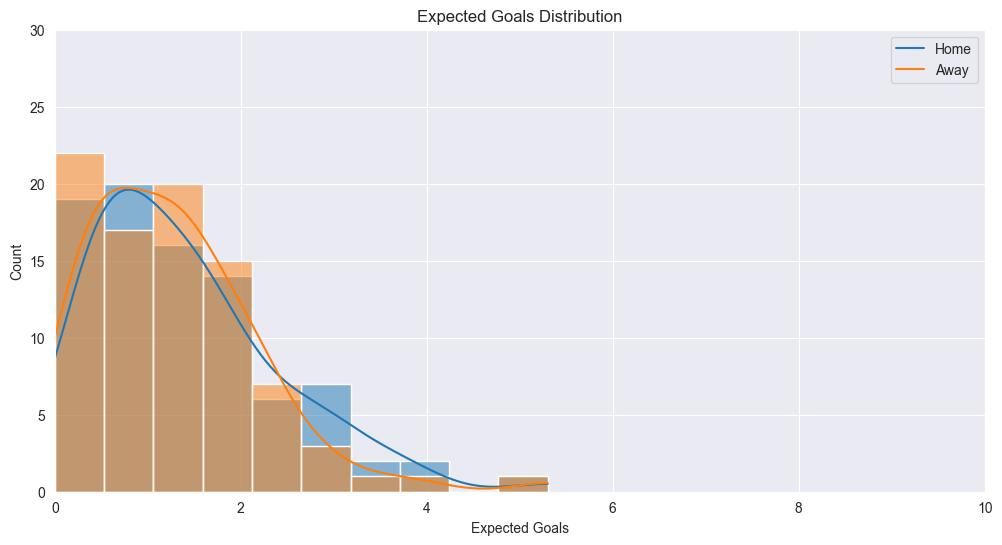

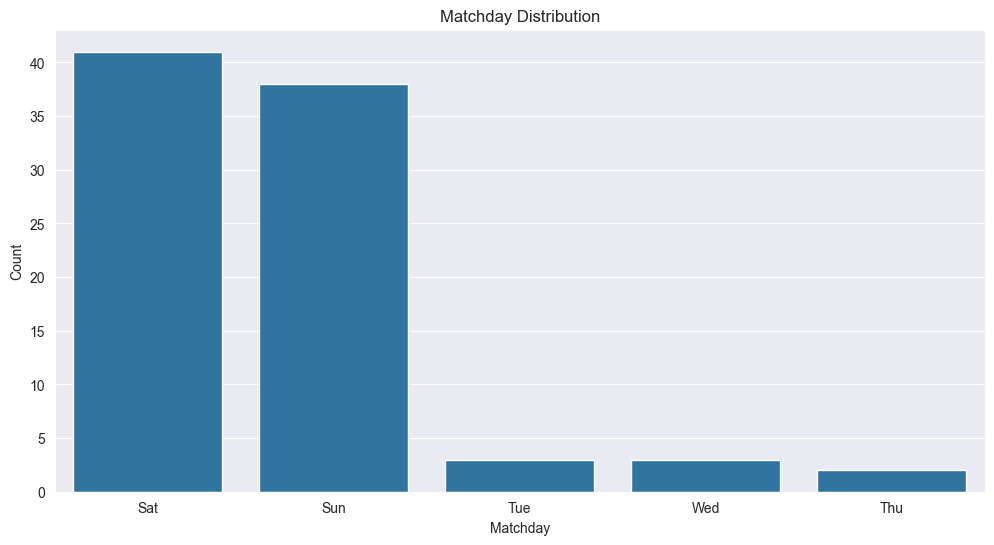

In [8]:
# Explore the statistical properties of the data, structure, features, etc.
display(data.sample(4))

# Histogram of scores in seaborn
plt.figure(figsize=(12,6))
sns.histplot(data['ScoreHome'], kde=True, stat='count', bins=10)
sns.histplot(data['ScoreAway'], kde=True, stat='count', bins=10)

plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')
plt.legend(['Home', 'Away'])
plt.xlim(0, 10)
plt.ylim(0, 30)

plt.show() 

# Histogram of Expected Goals in seaborn
plt.figure(figsize=(12,6))
sns.histplot(data['xGHome'], kde=True, stat='count', bins=10)
sns.histplot(data['xGAway'], kde=True, stat='count', bins=10)

plt.title('Expected Goals Distribution')
plt.xlabel('Expected Goals')
plt.ylabel('Count')
plt.legend(['Home', 'Away'])
plt.xlim(0, 10)
plt.ylim(0, 30)

plt.show() # Expected goals are more normally distributed than actual goals

# Barplot of Match days in seaborn
plt.figure(figsize=(12,6))
sns.barplot(x=data['Day'].value_counts().index, y=data['Day'].value_counts().values)

plt.title('Matchday Distribution')
plt.xlabel('Matchday')
plt.ylabel('Count')

plt.show()

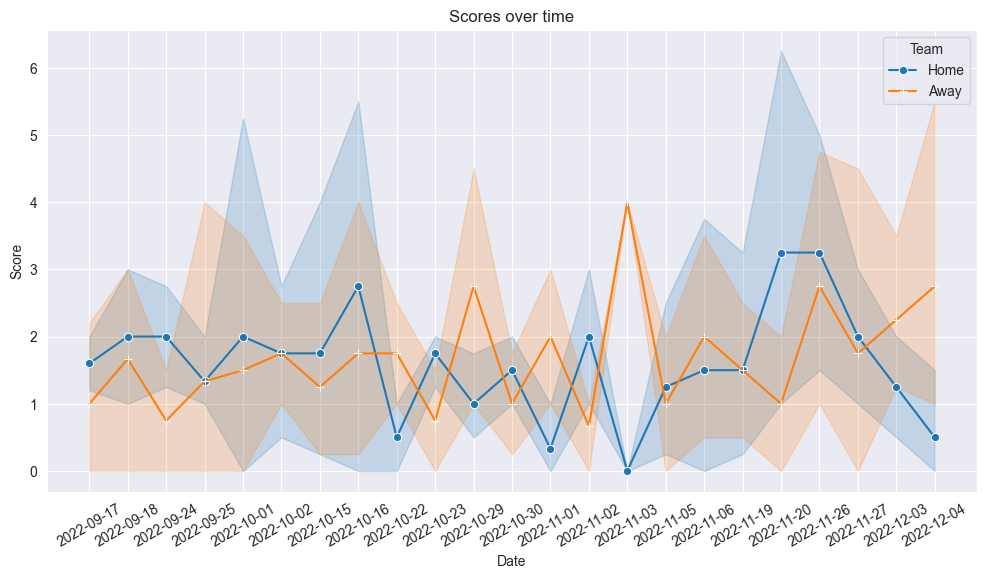

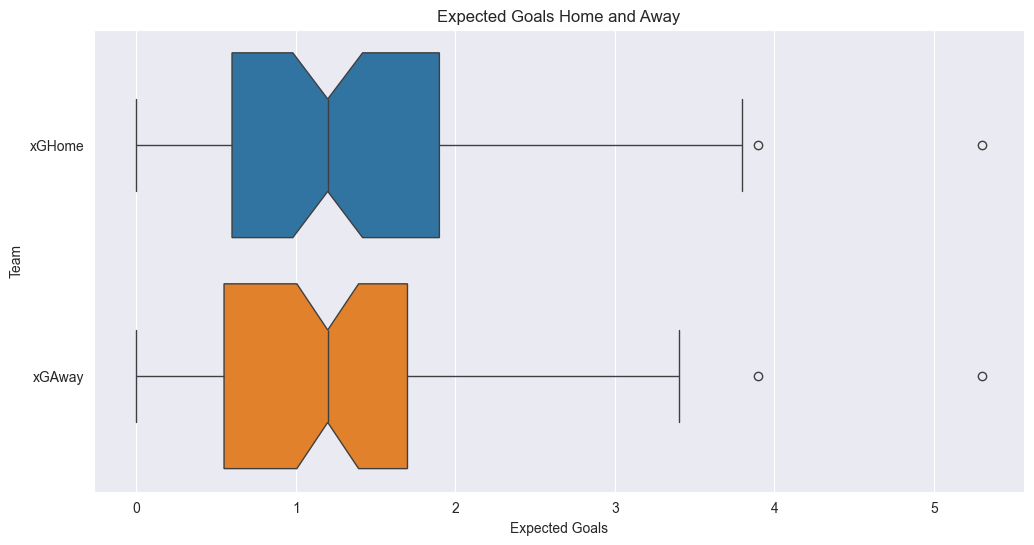

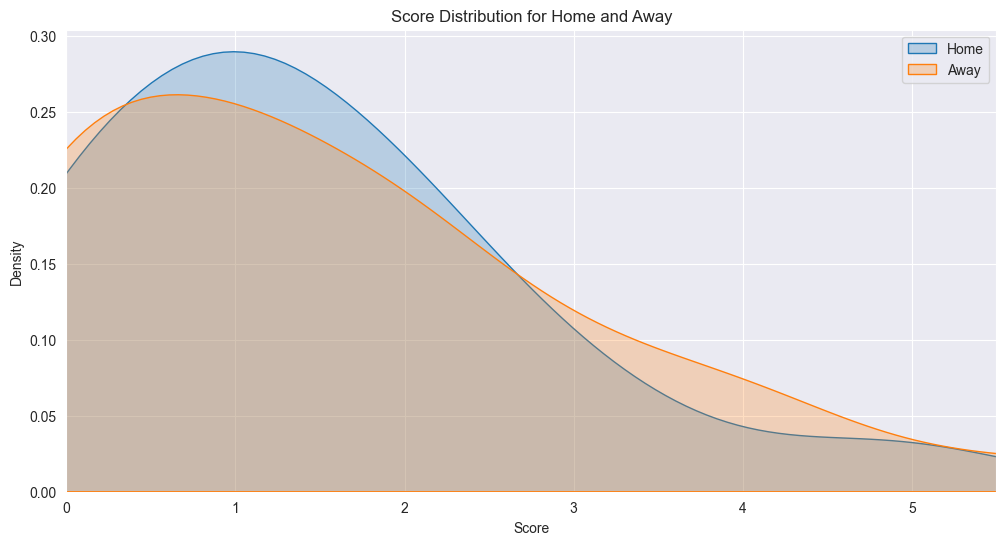

In [9]:
# LinePlot of Scores over time in seaborn
plt.figure(figsize=(12,6))

sns.lineplot(markers=True, marker='o', x='Date', y='ScoreHome', data=data, label='Home')
sns.lineplot(markers=True, marker='+', x='Date', y='ScoreAway', data=data, label='Away')

plt.xticks(rotation=30)
plt.title('Scores over time')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend(title='Team')

plt.show()

# Boxplot of Expected Goals Home and Away wo show the distribution of the data
plt.figure(figsize=(12,6))

sns.boxplot(data=data[['xGHome', 'xGAway']], notch=True, orient='h')

plt.title('Expected Goals Home and Away')
plt.xlabel('Expected Goals')
plt.ylabel('Team')

plt.show()
# ------------------------------------------------- Same as above but with the kdeplot
plt.figure(figsize=(12,6))

sns.kdeplot(x=data['ScoreHome'], shade=True)
sns.kdeplot(x=data['ScoreAway'], shade=True)

plt.title('Score Distribution for Home and Away')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend(['Home', 'Away'])
plt.xlim(0, 5.5)

plt.show()

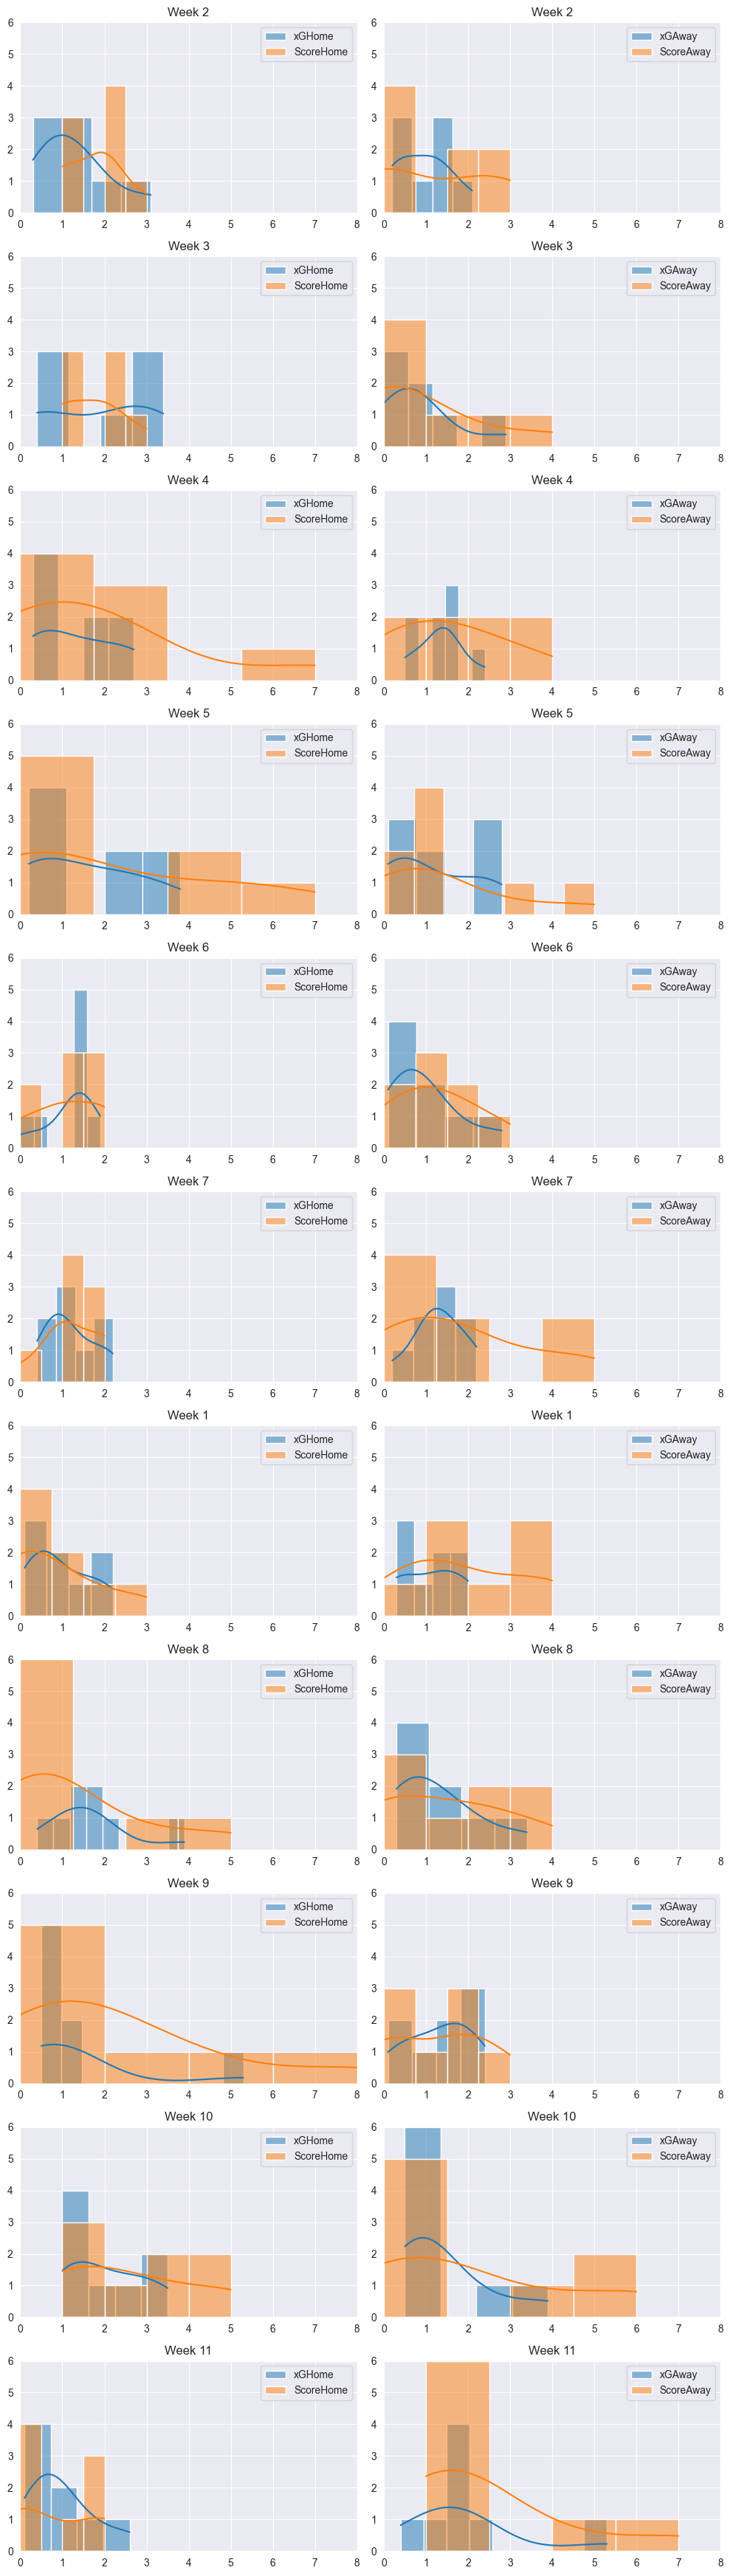

In [10]:
# Does the distribution of scores change as the weeks go by?
plt.figure(figsize=(10, 35))

integer_columns = ['xGHome', 'ScoreHome', 'xGAway', 'ScoreAway']
weeks = data['Wk'].unique()
num_weeks = len(weeks)
num_cols = len(integer_columns) // 2

for i, week in enumerate(weeks):
    plt.subplot(num_weeks, num_cols, i*num_cols+1)
    plt.ylim(0, 6)
    plt.xlim(0, 8)
    for col in integer_columns[:2]:
        sns.histplot(data[data['Wk'] == week][col], stat='count', kde=True, label=col)
    plt.title(f'Week {week}')
    plt.xlabel('')
    plt.ylabel('')
    plt.legend()

    plt.subplot(num_weeks, num_cols, i*num_cols+2)
    plt.ylim(0, 6)
    plt.xlim(0, 8)
    for col in integer_columns[2:]:
        sns.histplot(data[data['Wk'] == week][col], stat='count', kde=True, label=col)
    plt.title(f'Week {week}')
    plt.xlabel('')
    plt.ylabel('')
    plt.legend()

plt.tight_layout()
plt.show()

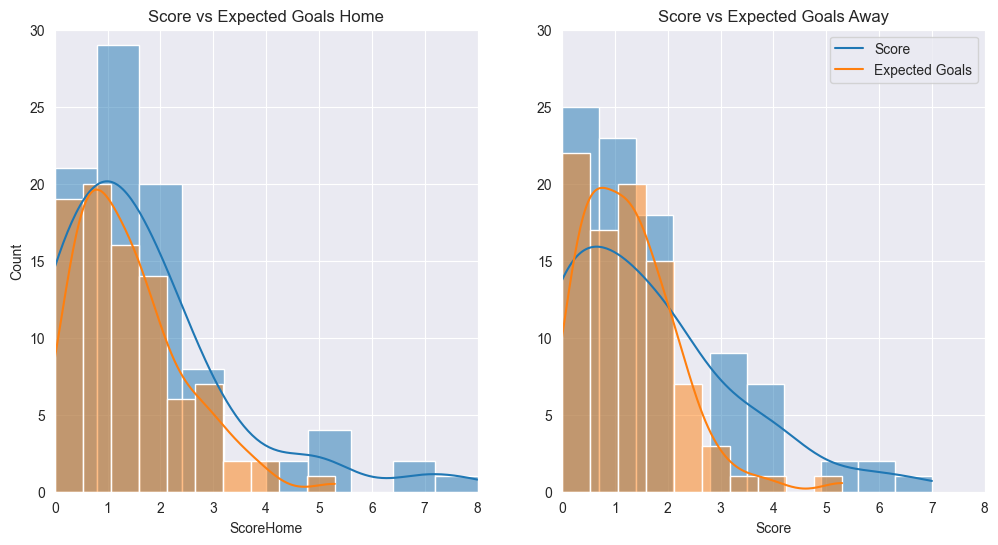

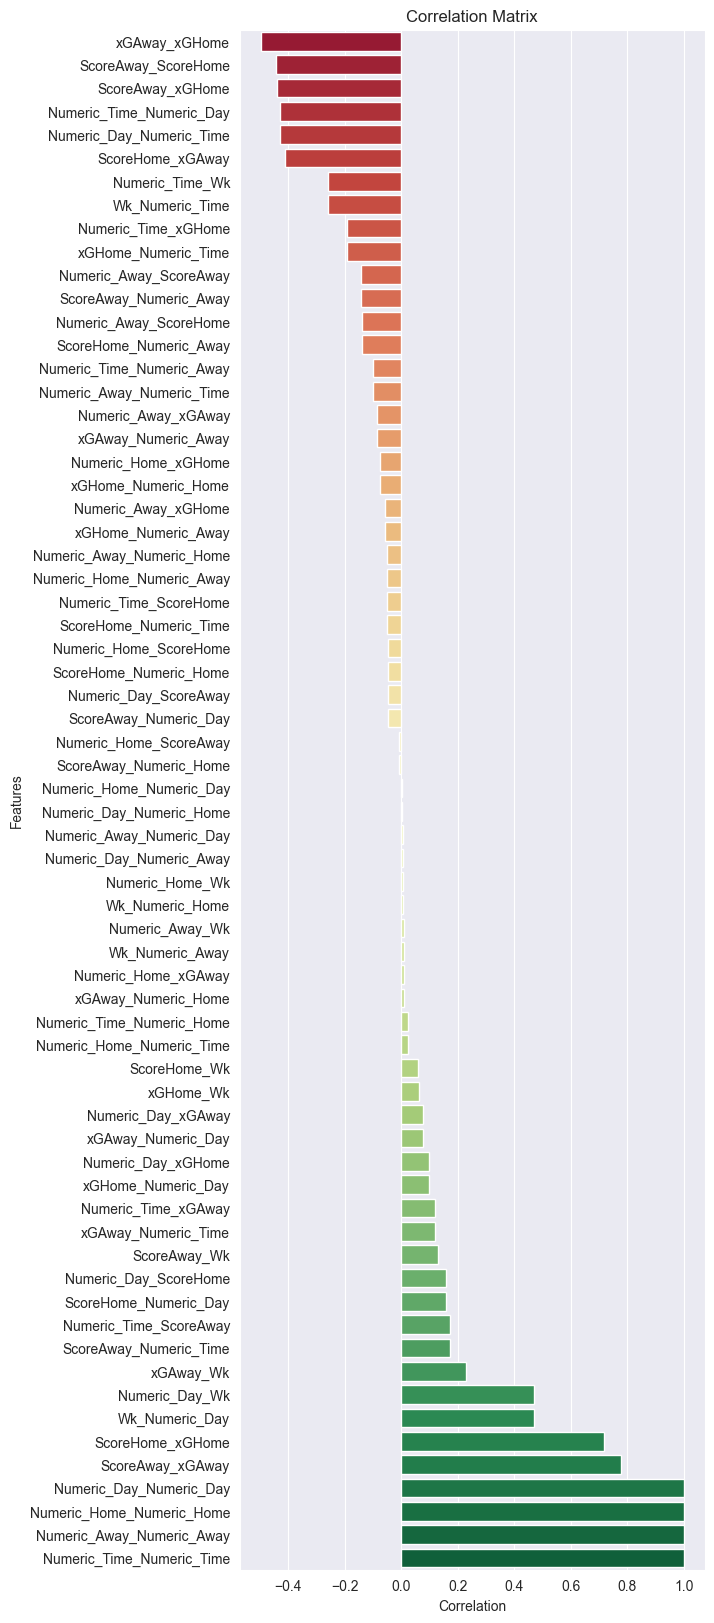

In [11]:
# Is there a correlation between the expected goals and the actual goals?
plt.figure(figsize=(12,6))

for i, col in enumerate(['Home', 'Away']):
    plt.subplot(1, 2, i+1)

    plt.xlim(0, 8)
    plt.ylim(0, 30)
    
    sns.histplot(x=f'Score{col}', data=data,  kde=True, stat='count', bins=10)
    sns.histplot(x=f'xG{col}', data=data,  kde=True, stat='count', bins=10)
    
    plt.title(f'Score vs Expected Goals {col}')

plt.xlabel('Score')
plt.ylabel('')
plt.legend(['Score', 'Expected Goals'])

plt.show() 

# Plot the correlation matrix
numeric_columns = data.select_dtypes(include=np.number).columns
correlations = data[numeric_columns].corr()
columns = correlations.columns
rows = correlations.index

corresponding = []
correlations_list = []

for col in columns:
    for row in rows:
        corresponding.append(row+'_'+col)

correlations = correlations.values.flatten()

for idx, value in enumerate(corresponding):
    correlations_list.append([value, correlations[idx]])   

processed_labels = set()
labels = []
values = []

for label, value in sorted(correlations_list, key=lambda x: x[1]):
    reverse_label = '_'.join(label.split('_')[::-1])
    
    if label not in processed_labels and reverse_label not in processed_labels and label != reverse_label:
        labels.append(label)
        values.append(value)
        processed_labels.add(label)

sorted_labels, sorted_values = zip(*sorted(zip(labels, values), key=lambda x: x[1]))


plt.figure(figsize=(6,20))

norm=TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
sns.barplot(y=sorted_labels, x=sorted_values, palette=sns.color_palette('RdYlGn', len(sorted_labels)), order=sorted_labels)

plt.xlabel('Correlation')
plt.ylabel('Features')
plt.title('Correlation Matrix')

plt.show()

# Modelling

## Baseline Model
Establish a baseline performance against which to compare future better models

In [12]:
train_baseline(features_home, target_home)
train_baseline(features_away, target_away)

Baseline error: 1.0
Baseline error: 0.802469135802469


## Other Models

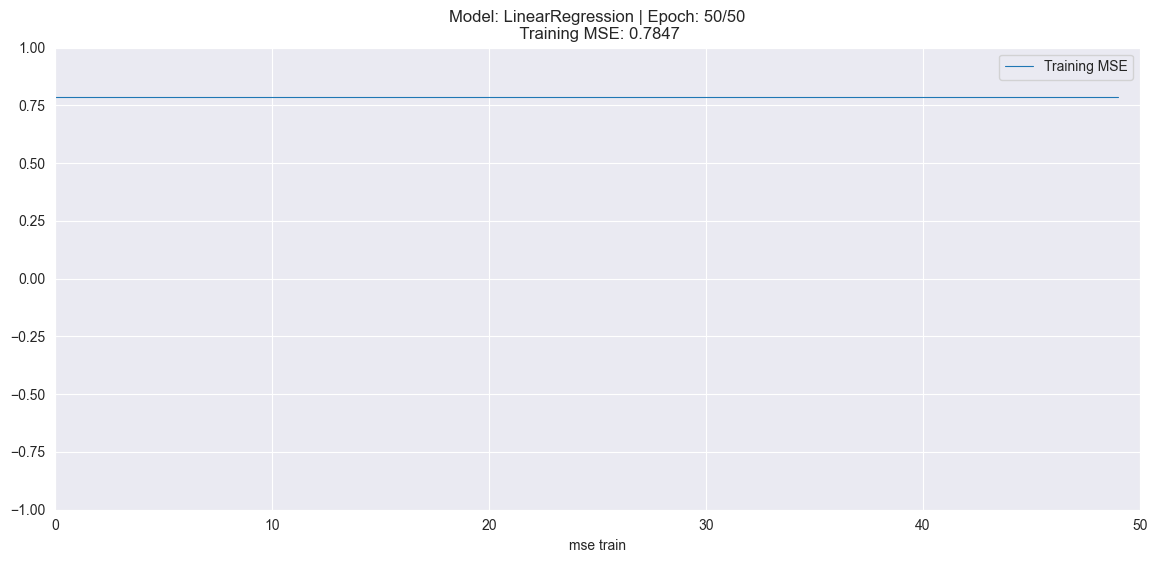

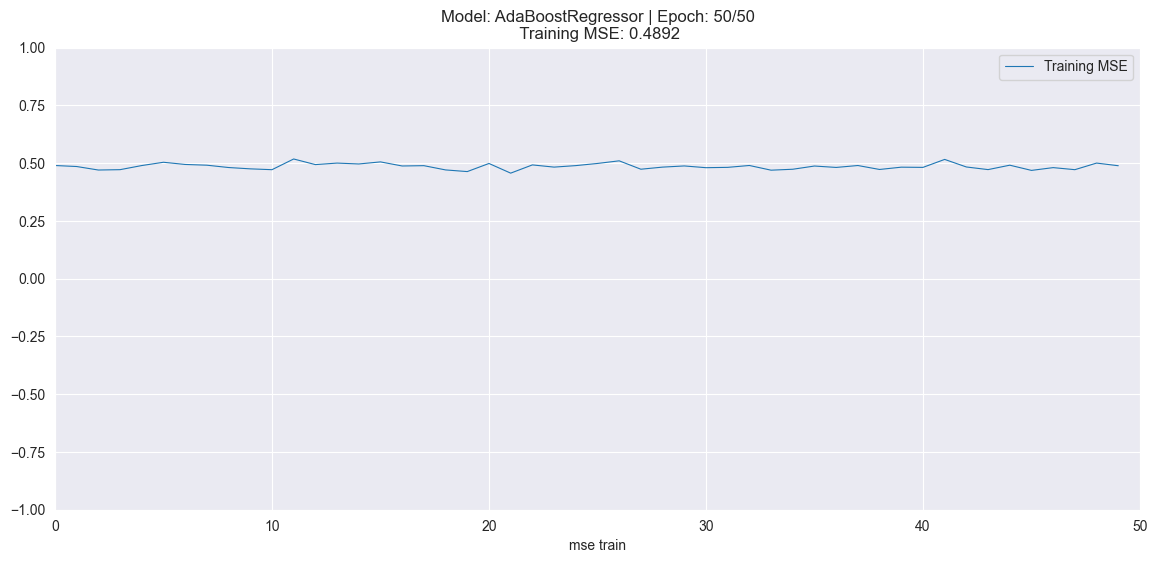

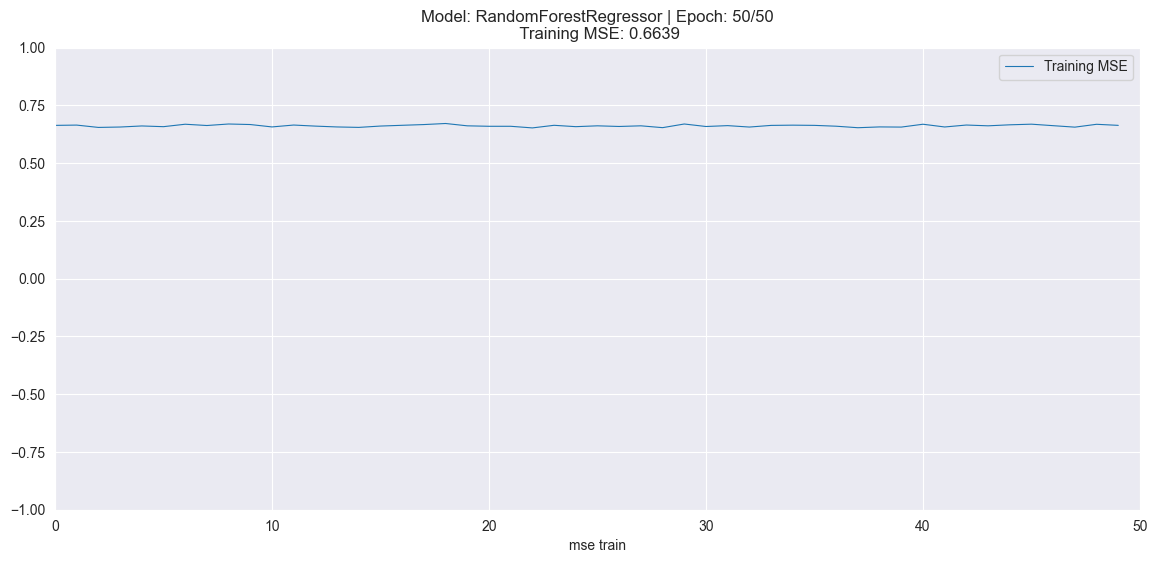

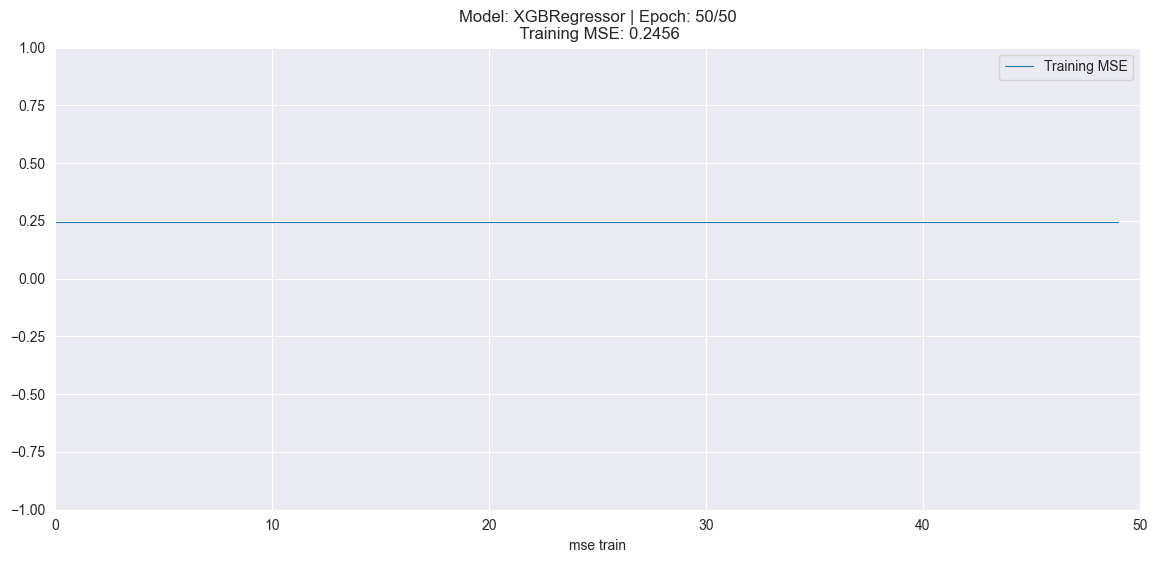

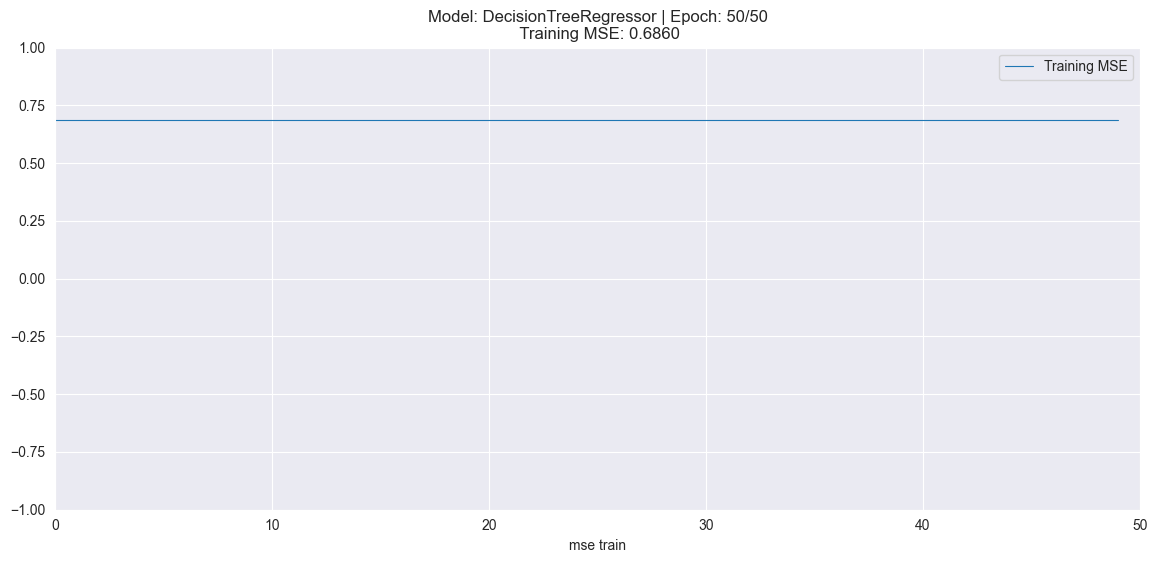

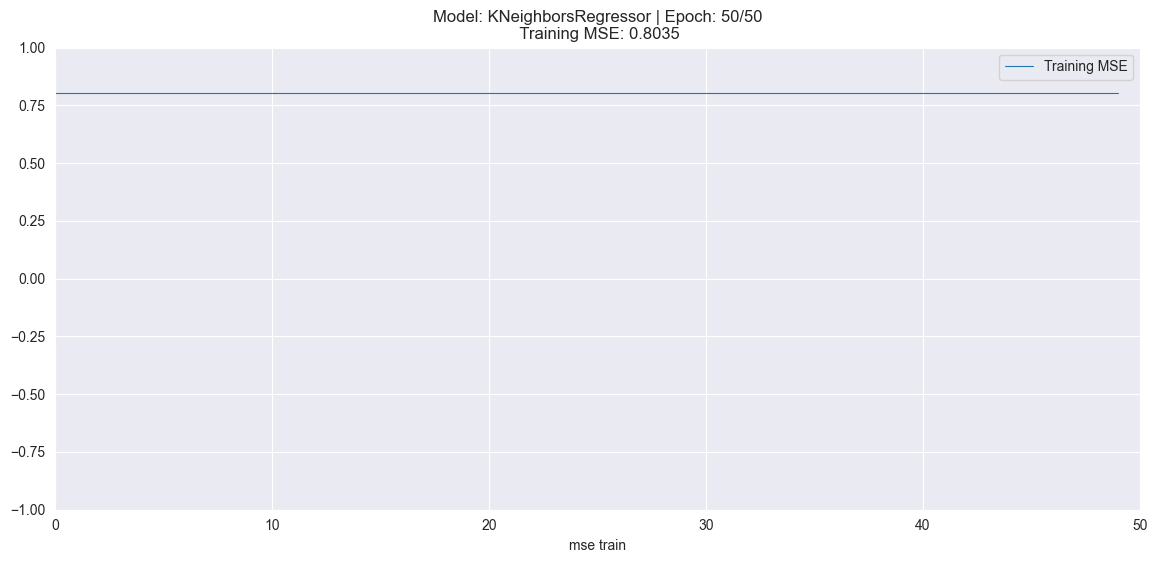

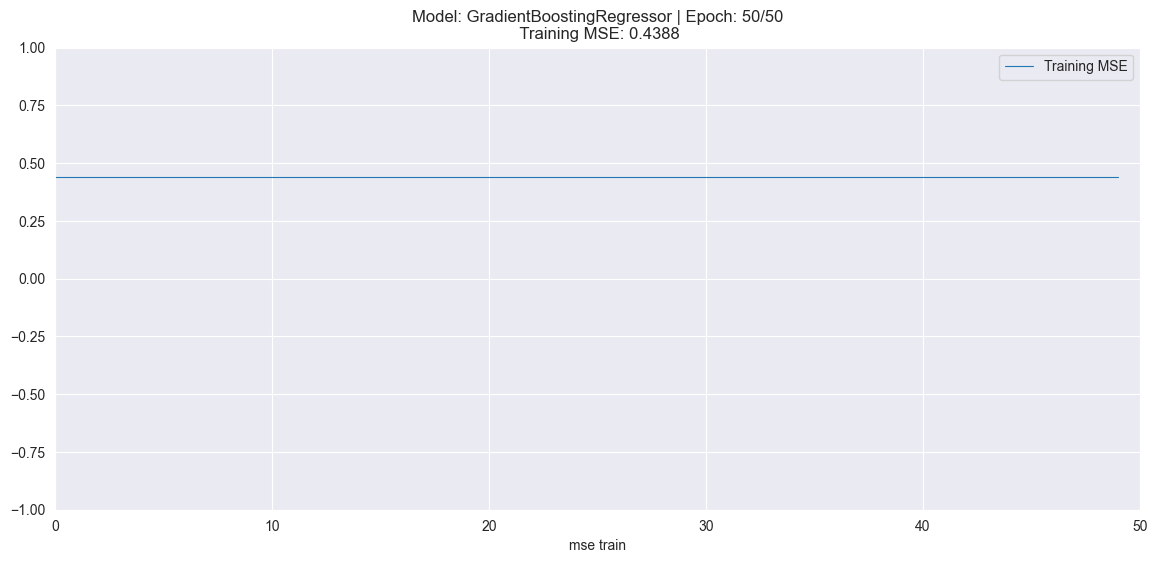

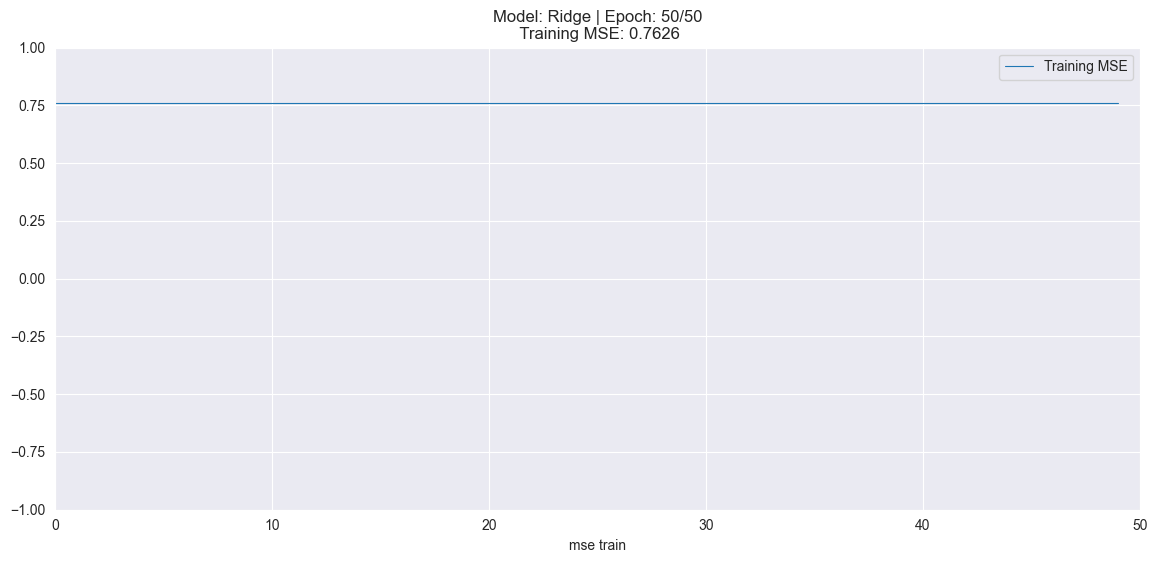

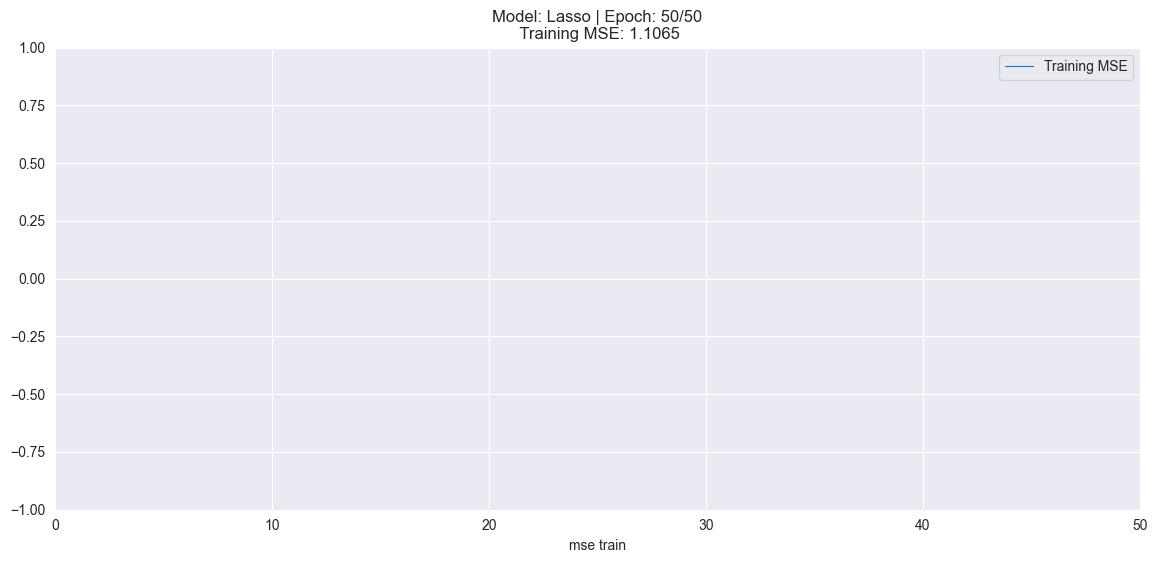

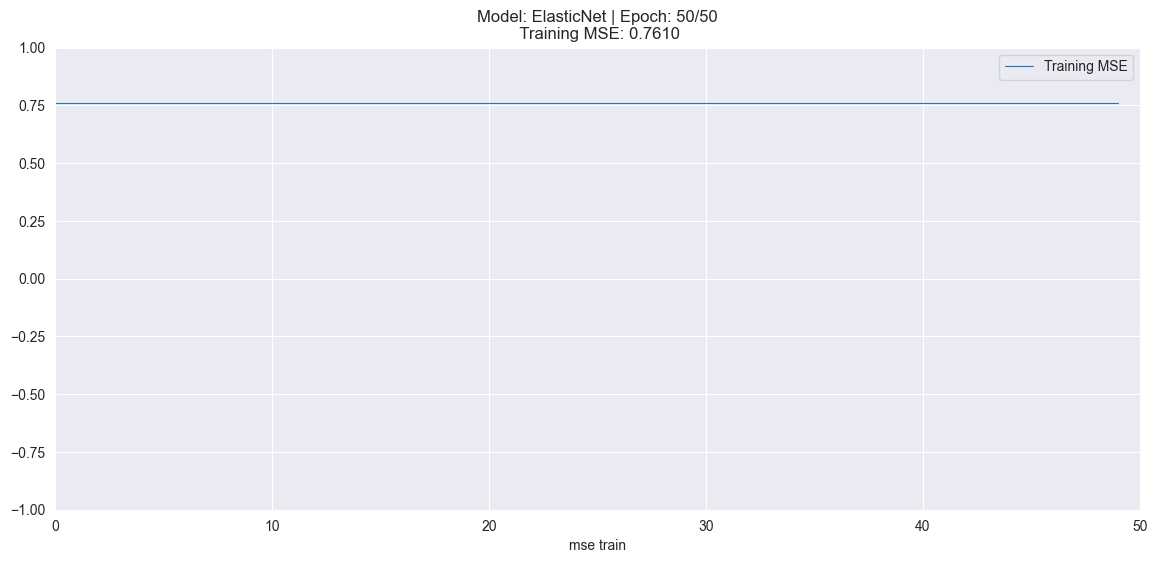

/Users/iffiness/.pyenv/versions/3.10.12/envs/virtual_airflow/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/iffiness/.pyenv/versions/3.10.12/envs/virtual_airflow/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


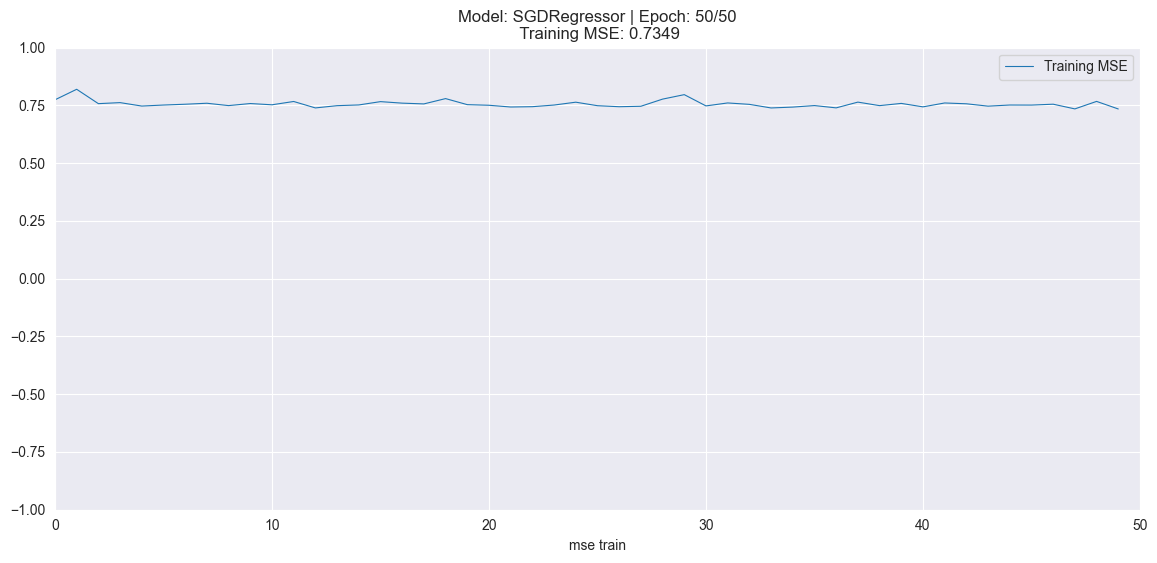

/Users/iffiness/.pyenv/versions/3.10.12/envs/virtual_airflow/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/iffiness/.pyenv/versions/3.10.12/envs/virtual_airflow/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/iffiness/.pyenv/versions/3.10.12/envs/virtual_airflow/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/iffiness/.pyenv/versions/3.10.12/envs/virtual_airflow/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/iffiness/.pyenv/versions/3.10.12/envs/virtual_airflow

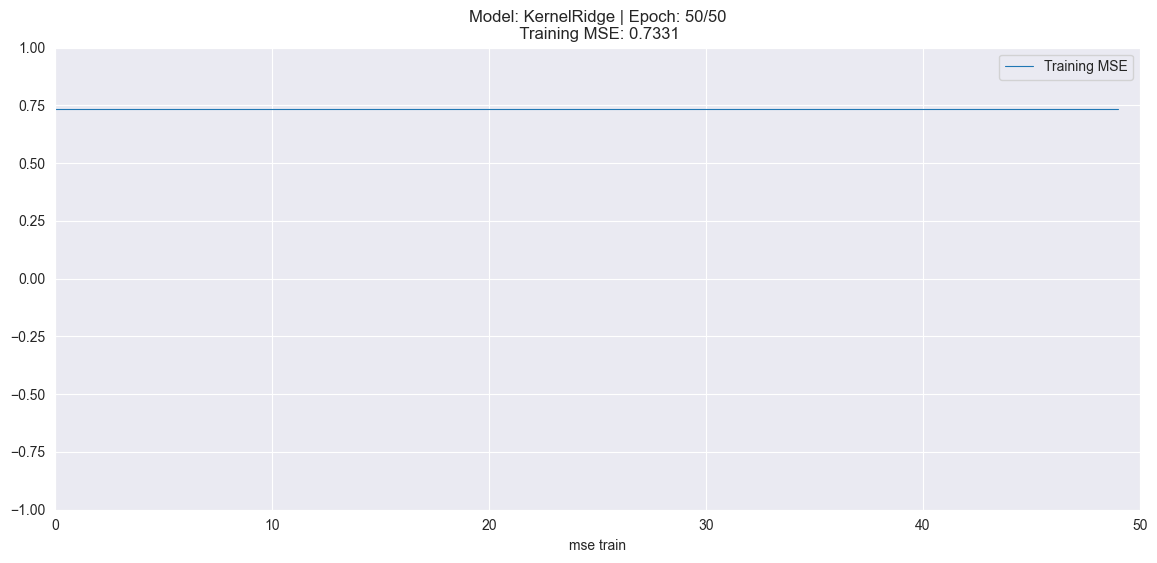

,model,params,mae,time
0,"XGBRegressor(base_score=None, booster=None, ca...","{'n_estimators': 50, 'max_depth': 2}",0.245623,0 days 00:00:10.028955
1,([DecisionTreeRegressor(criterion='friedman_ms...,"{'n_estimators': 50, 'max_depth': 2}",0.438793,0 days 00:00:18.310262
2,"(DecisionTreeRegressor(max_depth=3, random_sta...","{'n_estimators': 50, 'learning_rate': 0.1}",0.457065,0 days 00:00:32.949264
3,"(DecisionTreeRegressor(max_depth=2, max_featur...","{'n_estimators': 100, 'max_depth': 2}",0.652880,0 days 00:00:48.188406
4,DecisionTreeRegressor(max_depth=2),{'max_depth': 2},0.685990,0 days 00:00:01.071121
5,"KernelRidge(degree=2, gamma=0.01, kernel='poly')","{'kernel': 'poly', 'gamma': 0.01, 'degree': 2,...",0.733144,0 days 00:00:07.573412
6,"SGDRegressor(alpha=0.1, learning_rate='constan...","{'shuffle': True, 'penalty': 'l1', 'loss': 'sq...",0.734864,0 days 00:00:06.818220
7,"ElasticNet(alpha=1, l1_ratio=0.1)","{'l1_ratio': 0.1, 'fit_intercept': True, 'alph...",0.760954,0 days 00:00:01.402275
8,"Ridge(alpha=100, solver='lsqr')","{'solver': 'lsqr', 'fit_intercept': True, 'alp...",0.762633,0 days 00:00:01.498215
9,"LinearRegression(n_jobs=1, positive=True)","{'positive': True, 'n_jobs': 1, 'fit_intercept...",0.784684,0 days 00:00:06.572553


In [13]:

rankings_home = {}
training_process(rankings_home, features_home, target_home)
# train_model(rankings_home,'LinearRegression', features_home, target_home)
# train_model(rankings_home,'AdaBoostRegressor', features_home, target_home)
# train_model(rankings_home,'RandomForestRegressor', features_home, target_home)
# train_model(rankings_home,'XGBRegressor', features_home, target_home)
# # train_model(rankings_home,'DecisionTreeRegressor', features_home, target_home)
# # train_model(rankings_home,'KNeighborsRegressor', features_home, target_home)
# # train_model(rankings_home,'GradientBoostingRegressor', features_home, target_home)
# # train_model(rankings_home,'Ridge', features_home, target_home)
# # train_model(rankings_home,'Lasso', features_home, target_home)
# # train_model(rankings_home,'ElasticNet', features_home, target_home)
# # train_model(rankings_home,'SGDRegressor', features_home, target_home)
# # train_model(rankings_home,'KernelRidge', features_home, target_home)

# print(sorted(rankings_home.items(), key=lambda x: x[1]['mae']))

# Save models and their info
save_best_model('home',rankings_home)

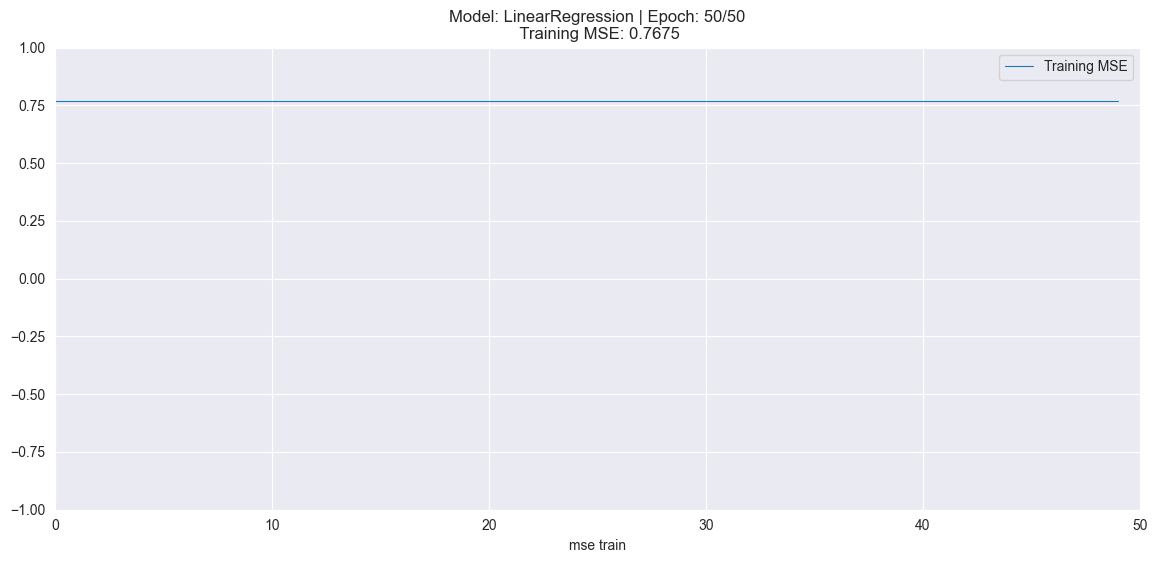

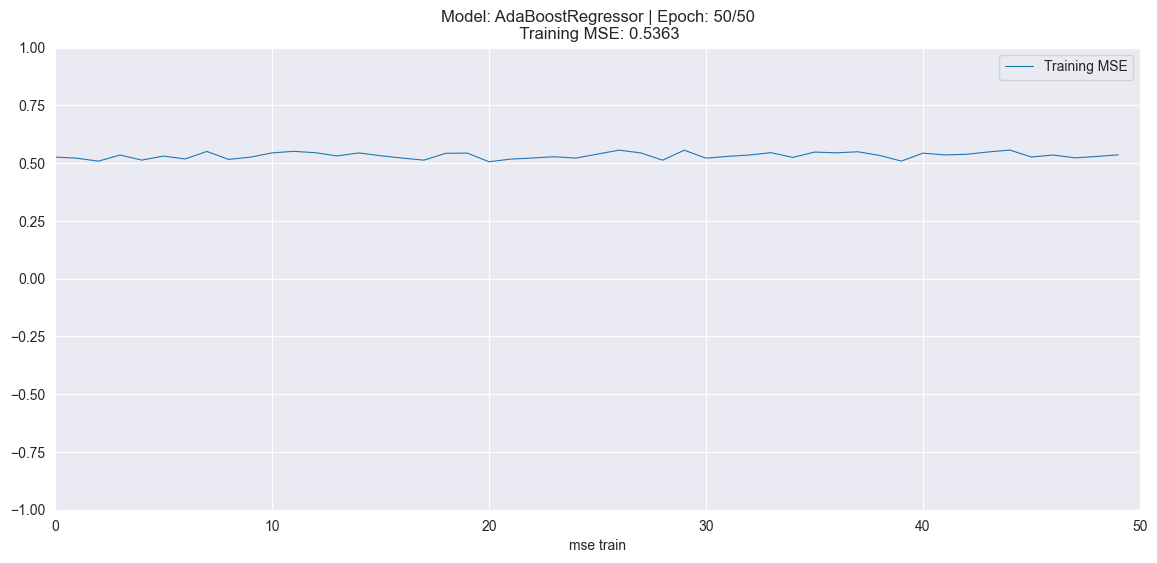

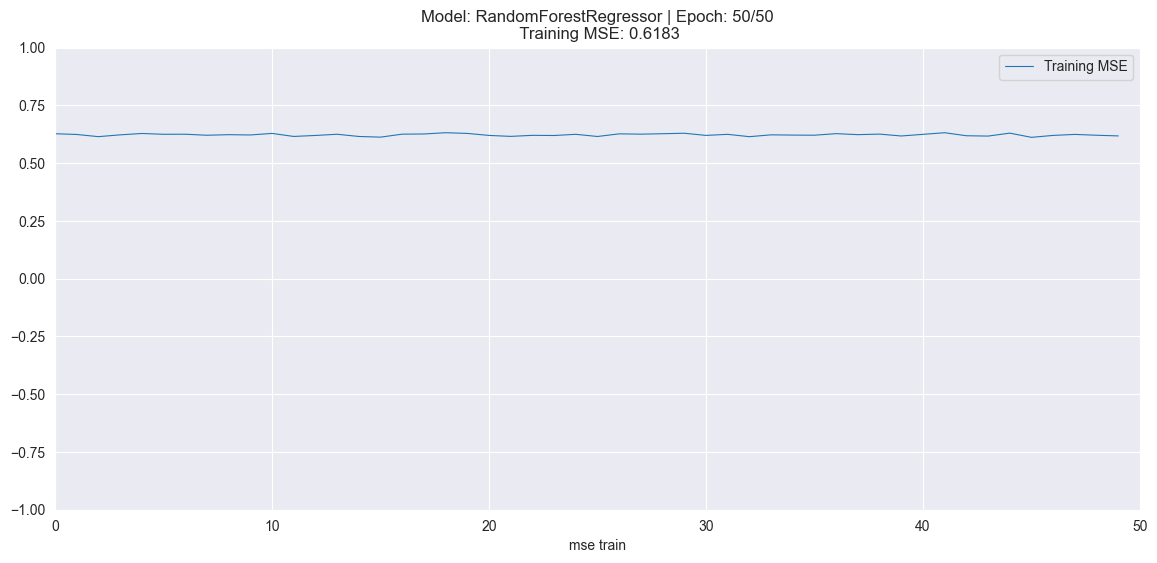

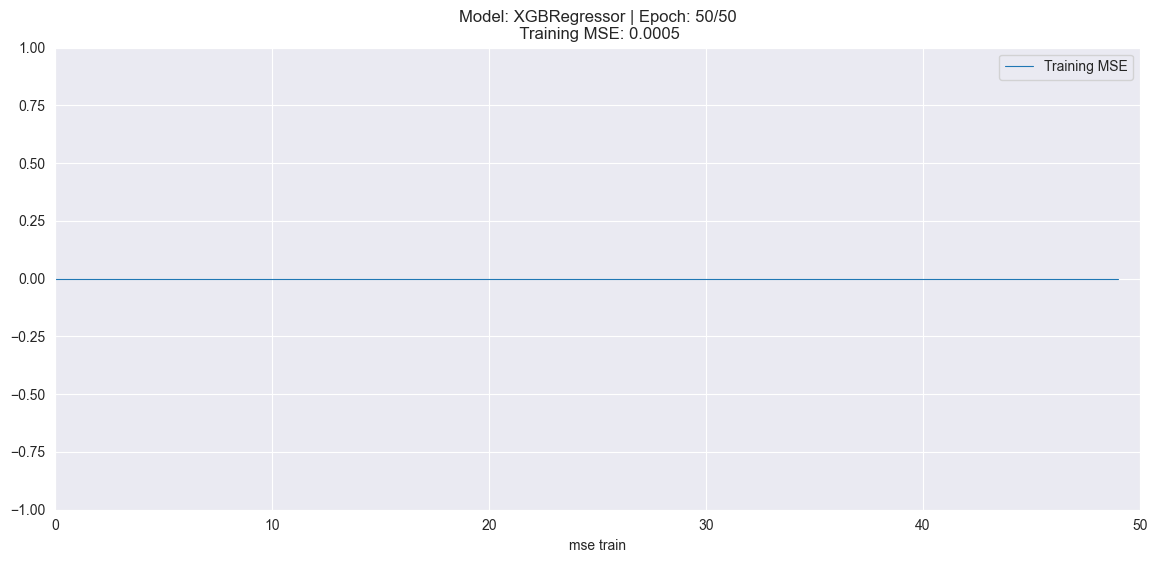

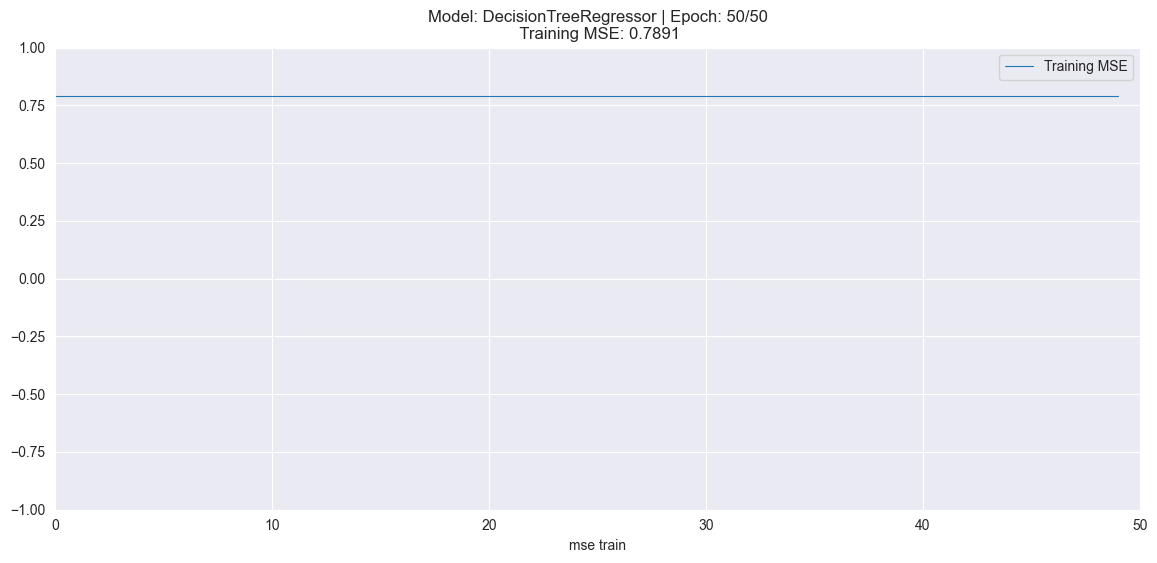

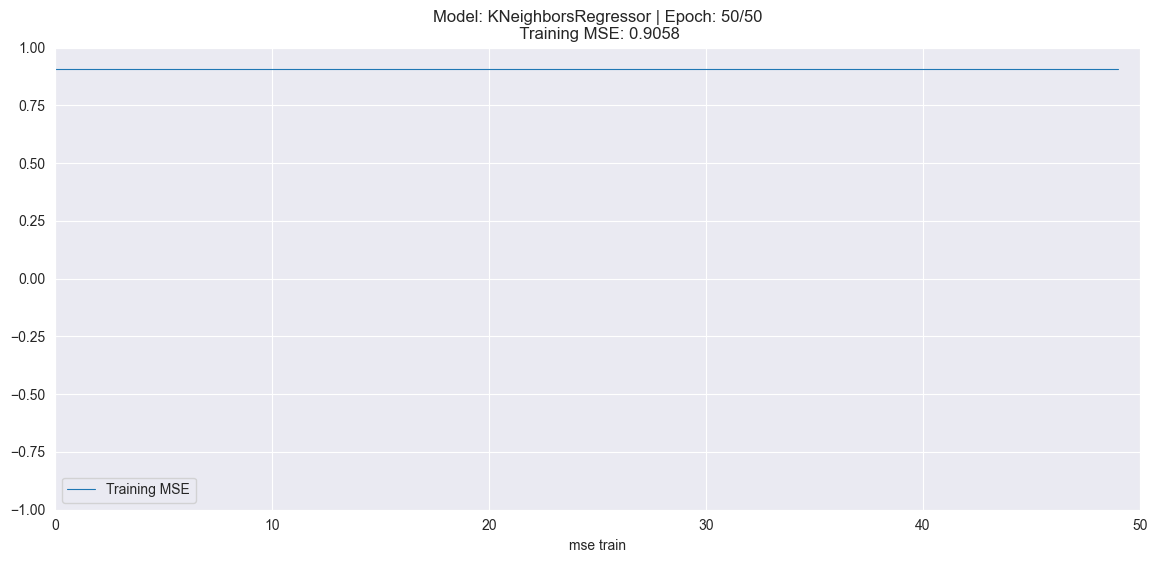

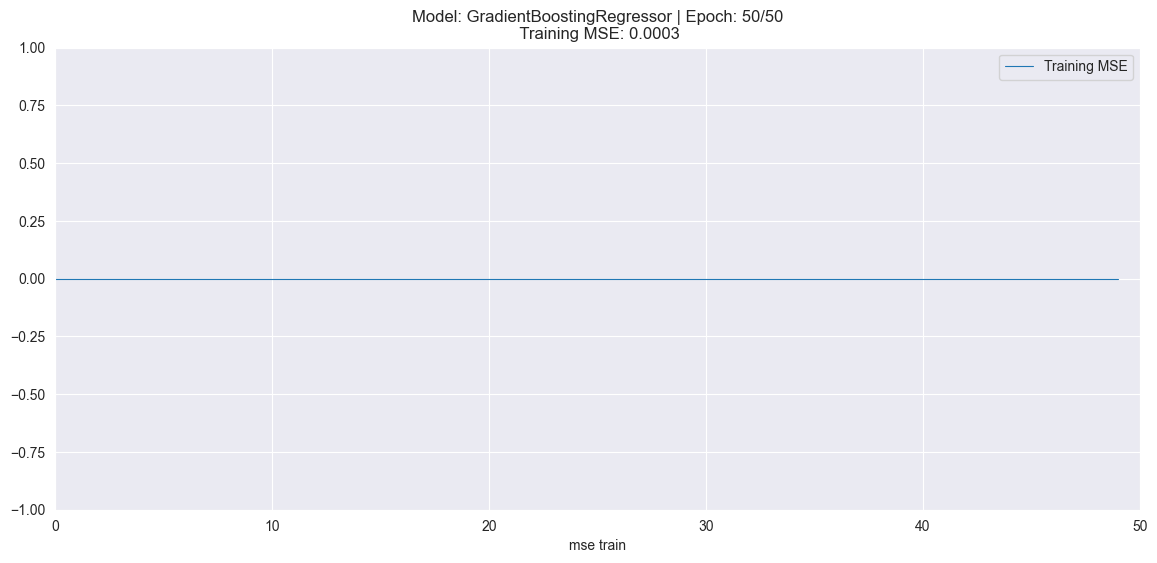

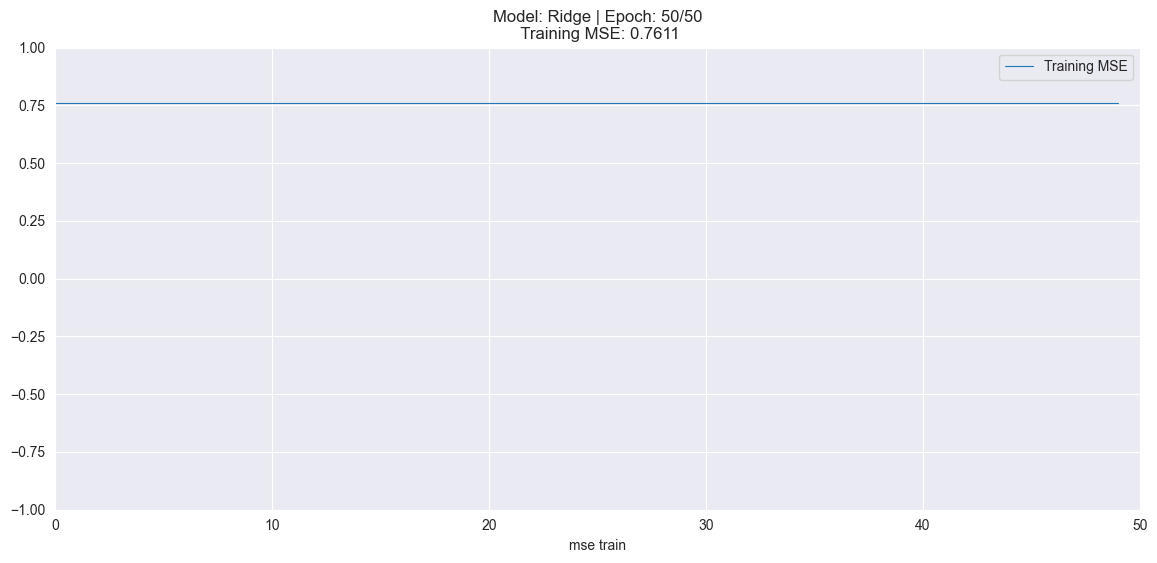

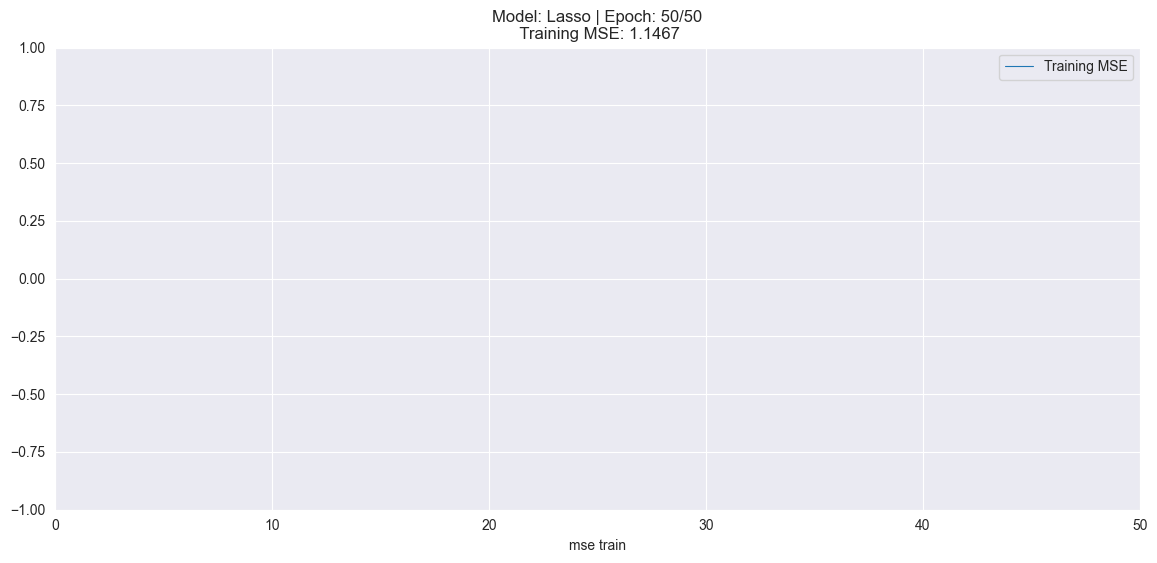

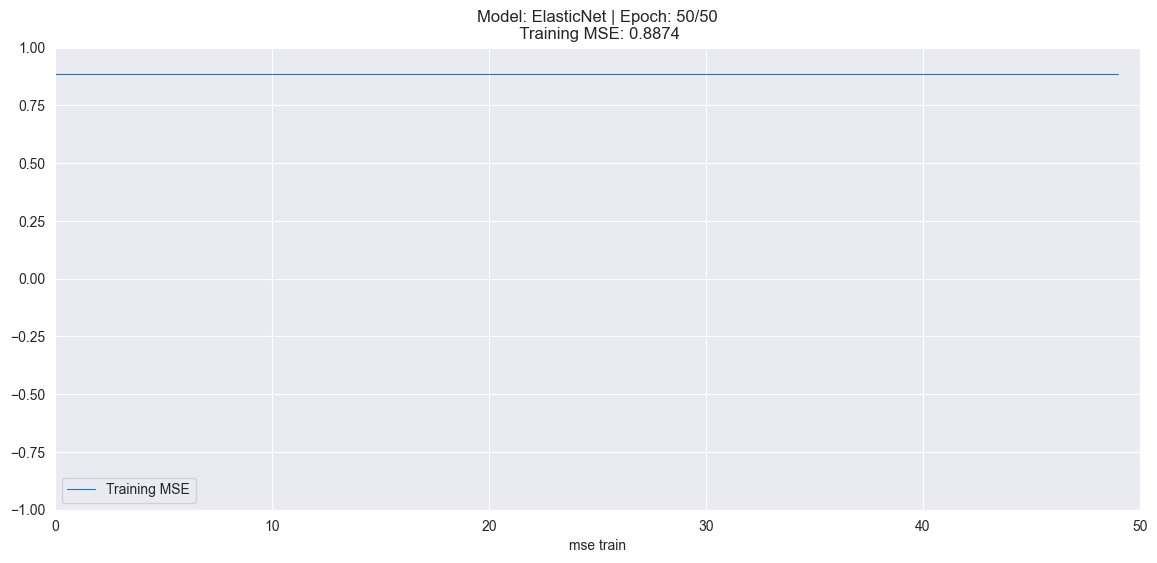

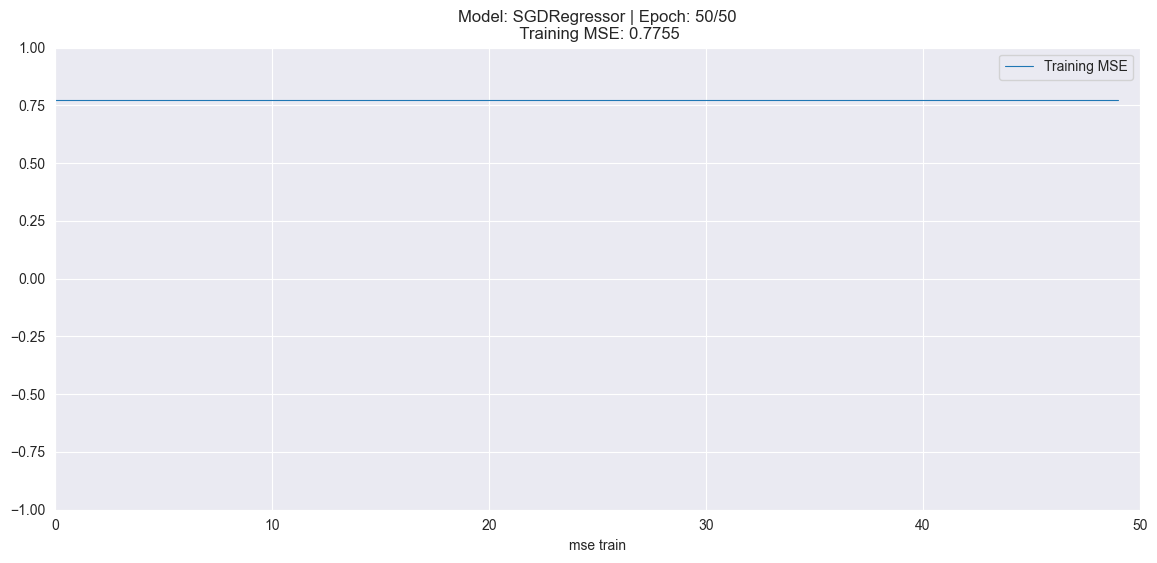

/Users/iffiness/.pyenv/versions/3.10.12/envs/virtual_airflow/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/iffiness/.pyenv/versions/3.10.12/envs/virtual_airflow/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/iffiness/.pyenv/versions/3.10.12/envs/virtual_airflow/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/iffiness/.pyenv/versions/3.10.12/envs/virtual_airflow/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/iffiness/.pyenv/versions/3.10.12/envs/virtual_airflow

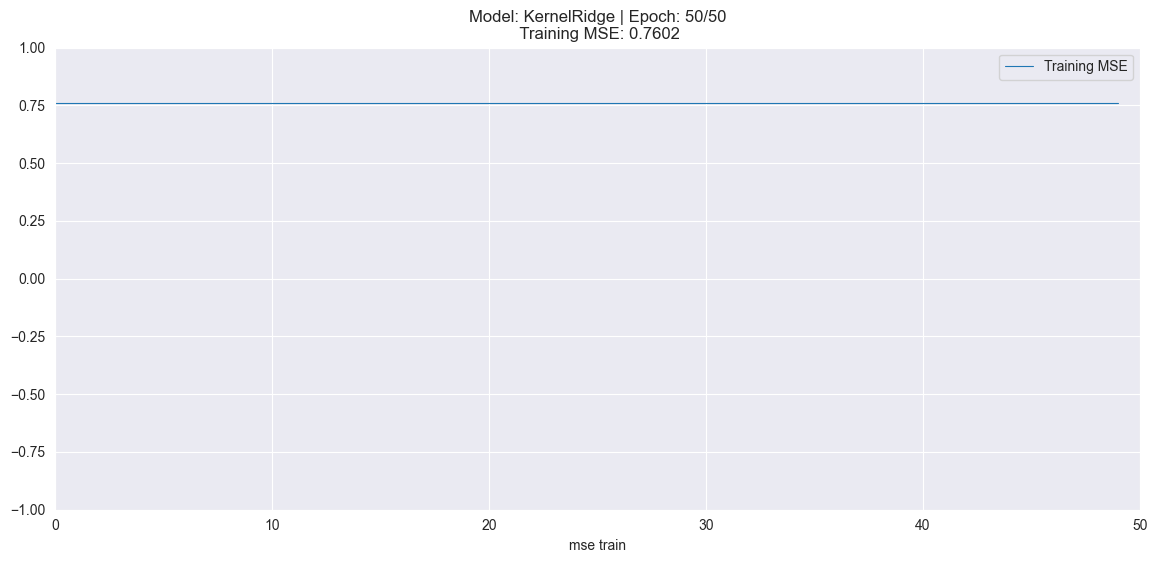

[('GradientBoostingRegressor', {'model': GradientBoostingRegressor(max_depth=5, n_estimators=150), 'params': {'n_estimators': 150, 'max_depth': 5}, 'mae': 0.0003438892508005384, 'time': datetime.timedelta(seconds=28, microseconds=305874)}), ('XGBRegressor', {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=N

,model,params,mae,time
0,([DecisionTreeRegressor(criterion='friedman_ms...,"{'n_estimators': 150, 'max_depth': 5}",0.000344,0 days 00:00:28.305874
1,"XGBRegressor(base_score=None, booster=None, ca...","{'n_estimators': 50, 'max_depth': 9}",0.000461,0 days 00:00:19.115749
2,"(DecisionTreeRegressor(max_depth=3, random_sta...","{'n_estimators': 50, 'learning_rate': 0.1}",0.506475,0 days 00:00:35.874240
3,"(DecisionTreeRegressor(max_depth=3, max_featur...","{'n_estimators': 150, 'max_depth': 3}",0.612050,0 days 00:00:58.624167
4,"KernelRidge(degree=1, gamma=1, kernel='poly')","{'kernel': 'poly', 'gamma': 1, 'degree': 1, 'a...",0.760170,0 days 00:00:08.620514
5,"Ridge(alpha=1, solver='lsqr')","{'solver': 'lsqr', 'fit_intercept': True, 'alp...",0.761135,0 days 00:00:01.675015
6,"LinearRegression(n_jobs=1, positive=True)","{'positive': True, 'n_jobs': 1, 'fit_intercept...",0.767520,0 days 00:00:01.250022
7,"SGDRegressor(alpha=0.1, learning_rate='optimal...","{'shuffle': False, 'penalty': 'l1', 'loss': 'e...",0.775466,0 days 00:00:07.803668
8,DecisionTreeRegressor(max_depth=2),{'max_depth': 2},0.789063,0 days 00:00:00.937337
9,"ElasticNet(alpha=1, l1_ratio=0.1)","{'l1_ratio': 0.1, 'fit_intercept': True, 'alph...",0.836318,0 days 00:00:01.608172


In [14]:
rankings_away = {}
training_process(rankings_away, features_away, target_away)
# train_model(rankings_away, 'LinearRegression', features_away, target_away)
# train_model(rankings_away, 'AdaBoostRegressor', features_away, target_away)
# train_model(rankings_away, 'RandomForestRegressor', features_away, target_away)
# train_model(rankings_away, 'XGBRegressor', features_away, target_away)
# train_model(rankings_away, 'DecisionTreeRegressor', features_away, target_away)
# train_model(rankings_away, 'KNeighborsRegressor', features_away, target_away)
# train_model(rankings_away, 'GradientBoostingRegressor', features_away, target_away)
# train_model(rankings_away, 'Ridge', features_away, target_away)
# train_model(rankings_away, 'Lasso', features_away, target_away)
# train_model(rankings_away, 'ElasticNet', features_away, target_away)
# train_model(rankings_away, 'SGDRegressor', features_away, target_away)
# train_model(rankings_away, 'KernelRidge', features_away, target_away)

print(sorted(rankings_away.items(), key=lambda x: x[1]['mae']))

# Save models and their info
save_best_model('away',rankings_away)

# Load Models from Pickle file

Load the models from the pickle to a REST API. I'm going to use _fastapi_

## Predictions

In [15]:
# ---- PREDICTIONS ----

# Pick random number between 0 and len(data)
random_index = np.random.randint(0, len(data))

In [16]:
# display(features_away[cols][random_index:random_index+1], features_home[cols][random_index:random_index+1])
# Predict home score for match at random index
predict_res(features_home[random_index:random_index+1])

    Wk  xGHome  xGAway  Numeric_Day  Numeric_Home  Numeric_Away  Numeric_Time  \
72  10     1.2     0.6            6             7            12           2.0   

    xGHome_xGAway_1  xGHome_xGAway_2  xGHome_xGAway_3  
72              1.2              0.6             0.72  


'predicting ... 2 : 2'

In [17]:
predict_res(features_away[random_index:random_index+1])

# The prediction is the same for both because the features are the same.

    Wk  xGHome  xGAway  Numeric_Day  Numeric_Home  Numeric_Away  Numeric_Time  \
72  10     1.2     0.6            6             7            12           2.0   

    xGHome_xGAway_1  xGHome_xGAway_2  xGHome_xGAway_3  
72              1.2              0.6             0.72  


'predicting ... 2 : 2'

In [18]:
display(features_home[random_index:random_index+1], target_home[random_index:random_index+1], target_away[random_index:random_index+1])

,Wk,xGHome,xGAway,Numeric_Day,Numeric_Home,Numeric_Away,Numeric_Time,xGHome_xGAway_1,xGHome_xGAway_2,xGHome_xGAway_3
72,10,1.2,0.6,6,7,12,2.0,1.2,0.6,0.72


72    2
Name: ScoreHome, dtype: int64

72    3
Name: ScoreAway, dtype: int64

## Use Streamlit to transform the data, load the model and do a prediction

In [19]:
print(..)

SyntaxError: invalid syntax (2448822055.py, line 1)

### ETL Process and Data Integration

__Apache Airflow__ supports a few databases: 
- SQLite _Lightweight filebased database suitable for small-scale deployments and testing_
- PostgreSQL _Relational database widely used in production environments_
- MySQL _Popular relational database widely used_
- Microsoft SQL Server _Commercial relational database widely used in enterprises_
- Oracle _Commercial relational database widely used in enterprises_
- Amazon RedShift _Cloud-based data warehouse optimized for analytics workloads_
- Google BigQuery _Cloud-based data warehouse optimized for analytics workloads_
- Apache Casssandra _Distributed No-SQL database optimized for high scalability and availability_
- Apache Hive _Data warehouse infrastructure for data summarization, querying and analytics_

I'm using SQLite because it's a small scale dataset

In [ ]:
# Load task
def load_data(matches):
    # Connect to database
    conn = sqlite3.connect('assets/spanish_matches.db')

    # Create cursor
    c = conn.cursor()

    # Create table
    c.execute("""CREATE TABLE IF NOT EXISTS matches (
        Wk INTERGER,
        Day TEXT,
        Date DATE,
        Time TIME,
        Home TEXT,
        xGHome FLOAT,
        Score TEXT,
        xGAway FLOAT,
        Away TEXT,
        xPHome FLOAT,
        xPAway FLOAT,
        ScoreHome INTERGER,
        ScoreAway INTERGER,
        GoalDifference INTERGER,
        Result TEXT,
        ExpectedGoalDifference FLOAT,
        Points INTERGER,
        ExpectedPoints INTERGER,
        WinPercentage FLOAT,
        TotalGoals INTERGER,
        xGRatio FLOAT
    )""")

    # Insert DataFrame records one by one.
    for i, row in matches.iterrows():
        c.execute("""INSERT INTO matches VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)""", (
            row['Wk'],
            row['Day'],
            row['Date'],
            row['Time'],
            row['Home'],
            row['xGHome'],
            row['Score'],
            row['xGAway'],
            row['Away'],
            row['xPHome'],
            row['xPAway'],
            row['ScoreHome'],
            row['ScoreAway'],
            row['GoalDifference'],
            row['Result'],
            row['ExpectedGoalDifference'],
            row['Points'],
            row['ExpectedPoints'],
            row['WinPercentage'],
            row['TotalGoals'],
            row['xGRatio']
        ))

    # Commit changes
    conn.commit()

    # Close cursor and connection
    c.close()
    conn.close()


In [ ]:
# Assign tasks
extract_task = PythonOperator(
    task_id='extract_data',
    python_callable=extract_data,
    dag=dag
)

transform_task = PythonOperator(
    task_id='transform_data',
    python_callable=transform_data,
    op_kwargs={'matches': '{{ ti.xcom_pull(task_ids="extract_data") }}'},
    dag=dag
)

load_task = PythonOperator(
    task_id='load_data',
    python_callable=load_data,
    op_kwargs={'matches': '{{ ti.xcom_pull(task_ids="transform_data") }}'},
    dag=dag
)

In [ ]:
!~/airflow_env/bin/airflow scheduler -D
!~/airflow_env/bin/airflow webserver -D

!~/airflow_env/bin/airflow dags list

!~/airflow_env/bin/airflow cheat-sheet

## Validation and Quality Assurance

To validate the quality of the data, I'm connecting to the database to check for null values in each column of the matches table.  
Specifically, I'll check the data type, the range anf completeness of the data

In [ ]:
# Validate data in the database and ensure the proper quality
def validate_data():
    # Connect to database
    conn = sqlite3.connect('assets/spanish_matches.db')

    # Create cursor
    c = conn.cursor()

    # Data type validation
    c.execute("""SELECT COUNT(*) FROM matches where CAST(Wk AS INTEGER) IS NULL""")
    null_count = c.fetchone()[0]
    if null_count == 0:
        print('Data type validation passed.')
    else:
        print(f'Data type validation failed with {null_count} null values.')

    # Data range validation
    c.execute("""SELECT COUNT(*) FROM matches where Wk < 1 OR Wk > 10""")
    range_count = c.fetchone()[0]
    if range_count == 0:
        print('Data range validation passed.')
    else:
        print(f'Data range validation failed with {range_count} values out of range.')

    # Data completeness validation
    c.execute("""SELECT COUNT(*) FROM matches where Wk IS NULL""")
    completeness_count = c.fetchone()[0]
    if completeness_count == 0:
        print('Data completeness validation passed.')
    else:
        print(f'Data completeness validation failed with {completeness_count} null values.')

    c.close()
    conn.close()

validate_task = PythonOperator(
    task_id='validate_data',
    python_callable=validate_data,
    op_kwargs={'matches': '{{ ti.xcom_pull(task_ids="load_data") }}'},
    dag=dag
)

# Define task dependencies
extract_task >> transform_task >> load_task >> validate_task

## Reporting and Analysis

Generate meaningful insights and reports.
- Trend analysis
- Team Performance analysis
- Team comparisons

In [ ]:
# Trend analysis
def trend_analysis():
    # Connect to database
    conn = sqlite3.connect('assets/spanish_matches.db')

    # Create cursor
    c = conn.cursor()

    # Data type validation
    c.execute("""SELECT * FROM matches""")
    matches = pd.DataFrame(c.fetchall())
    
    # Define plot function
    def plot_data():
        sns.lineplot(x='Date', y='TotlaGoals', data=matches)
        plt.title('Total Goals Scored')
        plt.xlabel('Date')
        plt.ylabel('Total Goals')
        plt.show()
    # Look at the correlation between the expected goals and the actual goals
    def calculate_correlation():
        corr_home = matches['xGHome'].corr(matches['ScoreHome'])
        print(f'Correlation between expected Goals for the Home and actual goals Home: {corr_home}')
        corr_away = matches['xGAway'].corr(matches['ScoreAway'])
        print(f'Correlation between expected Goals for the Away and actual goals Away: {corr_away}')
    
    plot_data()
    calculate_correlation()

trend_analysis_task = PythonOperator(
    task_id='trend_analysis',
    python_callable=trend_analysis,
    op_kwargs={'matches': '{{ ti.xcom_pull(task_ids="validate_data") }}'},
    dag=dag
)   

# Define task dependencies
extract_task >> transform_task >> load_task >> validate_task >> trend_analysis_task

In [ ]:
# Exectute the DAG workflow and view the results in the Airflow UI from scripts/DataPipelining.py
!~/airflow_env/bin/airflow trigger_dag 

In [ ]:
# Convert notebook to python script
!jupyter nbconvert --to script DataPipelining.ipynb --output-dir='airflow/dags/'